In [2]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.naive_bayes as nbyes
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
# Скачаем файлы базы
!rm -rf /content/sberbank_data_analysis/
!git clone https://github.com/fish34/sberbank_data_analysis.git
!unzip /content/sberbank_data_analysis/Project/courses_cleaned.zip


Cloning into 'sberbank_data_analysis'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 272 (delta 76), reused 103 (delta 44), pack-reused 97
Receiving objects: 100% (272/272), 59.53 MiB | 28.25 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Archive:  /content/sberbank_data_analysis/Project/courses_cleaned.zip
  inflating: courses_cleaned.csv     


In [4]:
df_all=pd.read_csv("/content/courses_cleaned.csv",index_col=0)

In [5]:
df_all.head()

,title,descr,marks,raiting,url,direction
0,Introduction to Big Data,"['interested', 'increasing', 'knowledge', 'big...",9666,4.6,https://www.coursera.org/learn/big-data-introd...,big data
1,"Big Data Essentials: HDFS, MapReduce and Spark...","['ever', 'heard', 'technologies', 'hdfs', 'map...",528,4.0,https://www.coursera.org/learn/big-data-essent...,big data
2,"Big Data, Artificial Intelligence, and Ethics","['course', 'gives', 'context', 'experience', '...",317,4.6,https://www.coursera.org/learn/big-data-ai-ethics,big data
3,Introduction to Data Engineering,"['course', 'introduces', 'core', 'concepts', '...",57,4.6,https://www.coursera.org/learn/introduction-to...,big data
4,Data-driven Decision Making,"['welcome', 'decision', 'making', 'course', 'l...",5451,4.6,https://www.coursera.org/learn/decision-making,big data


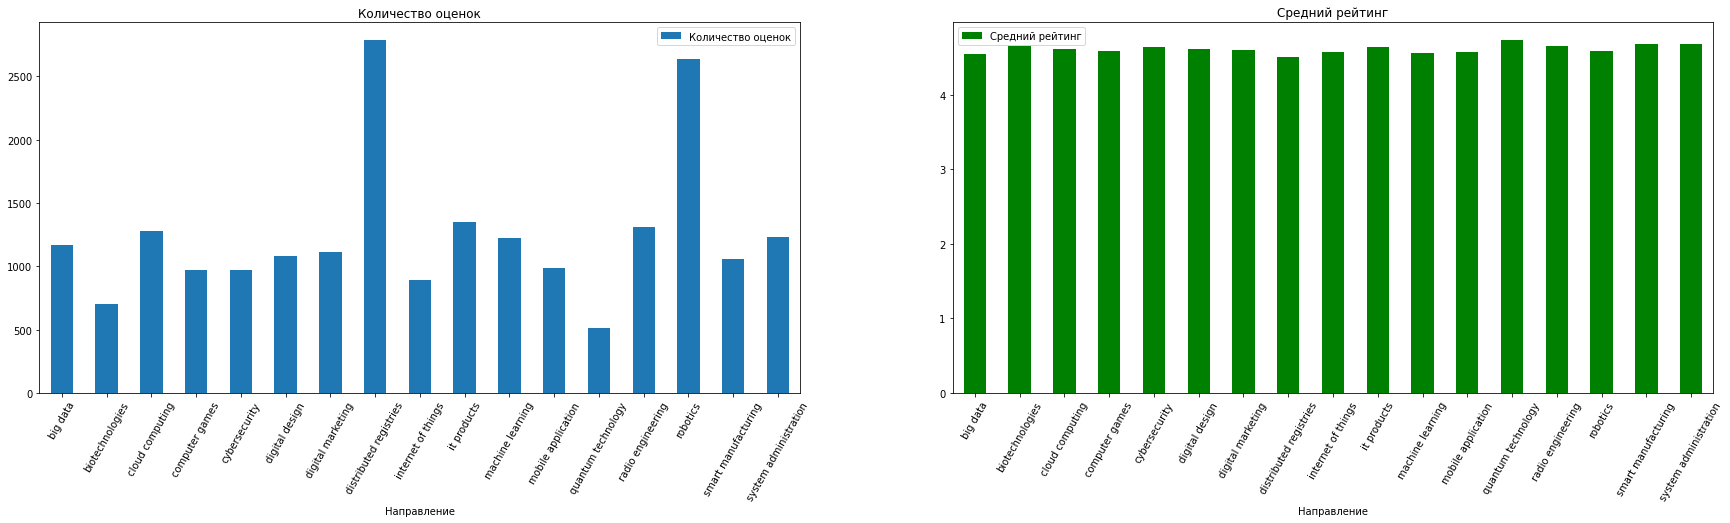

In [8]:
# Выведем на гистограмме среднее значение оценок и рейтинга по каждому направлению

plt.figure(figsize=(30,15))
plt.subplot(2,2,1)
ax=plt.gca()
df_all.groupby(['direction'])['marks'].mean().plot.bar()
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Количество оценок')
ax.legend(labels=['Количество оценок'])

plt.subplot(2,2,2)
ax=plt.gca()
df_all.groupby(['direction'])['raiting'].mean().plot.bar(color='green')
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Средний рейтинг')
ax.legend(labels=['Средний рейтинг'])

plt.show()

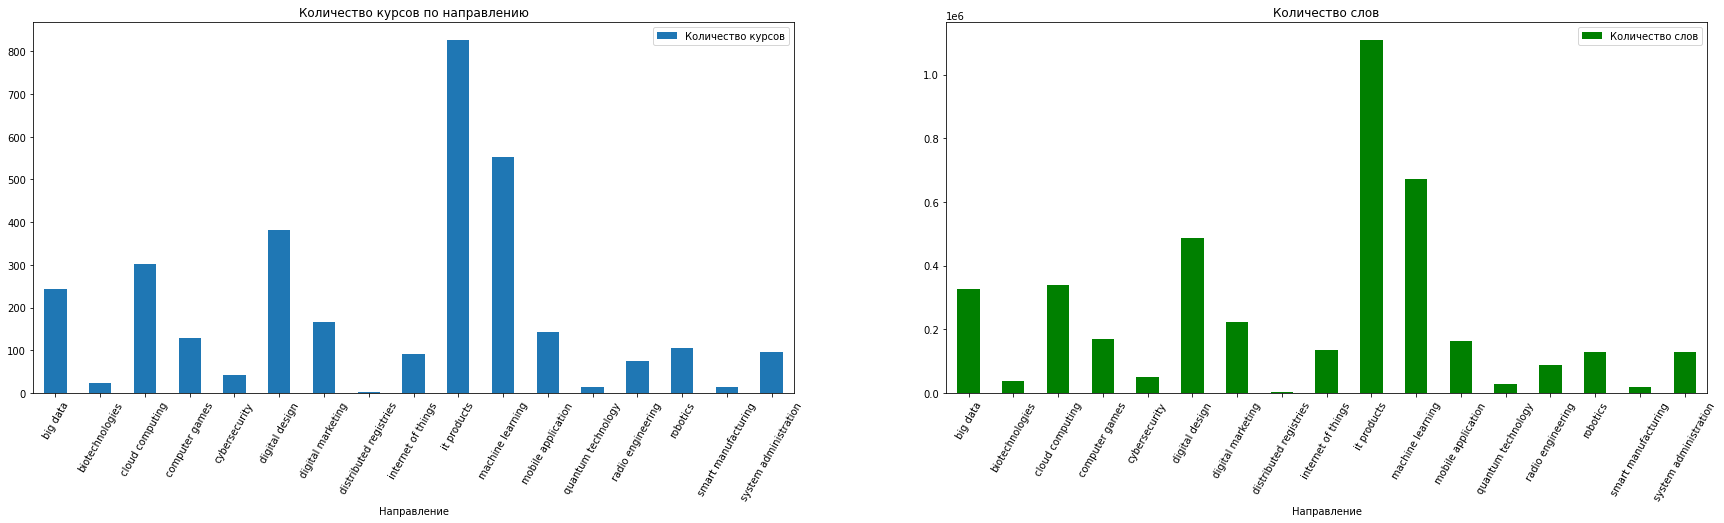

In [16]:
# Отобразим гистограмму количества специализаций и курсов по каждому направлению. Видно, что выборка несбалансирована, значительное число курсов приходится на направление [it products]
# Отобразим балансировку числа слов от направлений. Так же видна несбалансированность числа слов от направлений.
plt.figure(figsize=(30,15))

plt.subplot(2,2,1)
ax=plt.gca()
df_all.groupby(['direction'])['direction'].count().plot.bar()
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Количество курсов по направлению')
ax.legend(labels=['Количество курсов'])

plt.subplot(2,2,2)
ax=plt.gca()
df_all['words count']=df_all['descr'].str.len()
df_all_hist=df_all.groupby(['direction'])['words count'].sum().plot.bar(color='green')
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Количество слов')
ax.legend(labels=['Количество слов'])

plt.show()

In [29]:
# Выделим данные для построения модели.
courses=df_all[['descr','direction']]

In [30]:
#Закодируем целевую переменную - направление.
encoders = {}
encoders['direction'] = preprocessing.LabelEncoder() # для колонки direction создаем кодировщик
courses['direction'] = encoders['direction'].fit_transform(courses['direction']) # применяем кодировщик к столбцу и перезаписываем столбец

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
courses

,descr,direction
0,"['interested', 'increasing', 'knowledge', 'big...",0
1,"['ever', 'heard', 'technologies', 'hdfs', 'map...",0
2,"['course', 'gives', 'context', 'experience', '...",0
3,"['course', 'introduces', 'core', 'concepts', '...",0
4,"['welcome', 'decision', 'making', 'course', 'l...",0
...,...,...
3210,"['goal', 'course', 'equip', 'learners', 'safel...",16
3211,"['college', 'confusing', 'intimidating', 'help...",16
3212,"['course', 'early', 'career', 'researchers', '...",16
3213,"['around', 'world', 'increasingly', 'socially'...",16


In [32]:
# Данные для анализа - направление и описание
X=courses['descr'].values
y=courses['direction'].values

In [36]:
# Класс для анализа. Используем TF-IDF трансформацию и NB классификатор по умолчанию.
class Classifier():
  def __init__(self,X,y,model = None):
    self.model=model or nbyes.ComplementNB()
    # Разделим выборку на тренировочную и проверочную
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=.15, random_state=33)
    # Трансформируем данные и наполним словарь
    self.vectorizer = TfidfVectorizer(ngram_range = (1,2))
    # Convert a collection of raw documents to a matrix of TF-IDF features.
    self.X_train = self.vectorizer.fit_transform(self.X_train)
    # Tf-idf-weighted document-term matrix
    self.X_test = self.vectorizer.transform(self.X_test)
    self.future_names = self.vectorizer.get_feature_names()
    # Тренируем модель
    self.model.fit(self.X_train, self.y_train)

  def classify(self, text):
    text_counts = self.vectorizer.transform(text)
    cls=self.model.predict(text_counts)
    self.predictions = encoders["direction"].inverse_transform(cls)
    self.predictions_c = self.model.predict_proba(text_counts)
    print(f'Predictions: {self.predictions}')
    print(f'Predictions for all classes: {self.predictions_c}')
    return self.predictions
  
  def getReport(self):
    self.y_predictions = self.model.predict(self.X_test)
    print(classification_report(self.y_test, self.y_predictions))

In [37]:
# Показатели модели
# accuracy — доля правильных ответов алгоритма
# Для оценки качества работы алгоритма на каждом из классов по отдельности введем метрики precision (точность) и recall (полнота)
model_nb = Classifier(X,y)
model_nb.getReport()

              precision    recall  f1-score   support

           0       0.09      0.05      0.07        37
           1       0.00      0.00      0.00         5
           2       0.18      0.19      0.18        59
           3       0.18      0.12      0.15        16
           4       0.00      0.00      0.00         5
           5       0.06      0.04      0.05        52
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        18
           9       0.30      0.57      0.39       119
          10       0.39      0.30      0.34        90
          11       0.11      0.06      0.07        18
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00        15

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


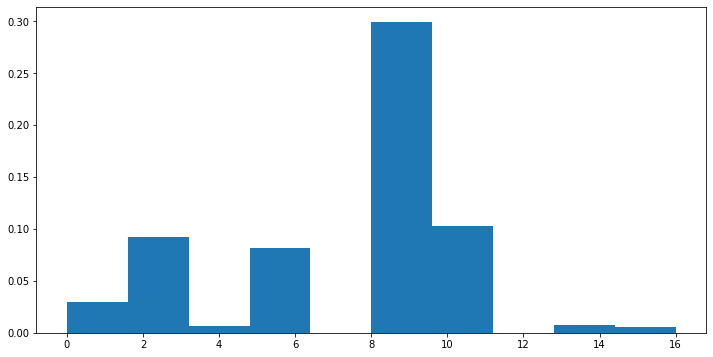

In [38]:
# Отобразим данные тестовых предсказаний
plt.figure(figsize=(12, 6))
plt.hist(model_nb.y_predictions, density=True)
plt.show()

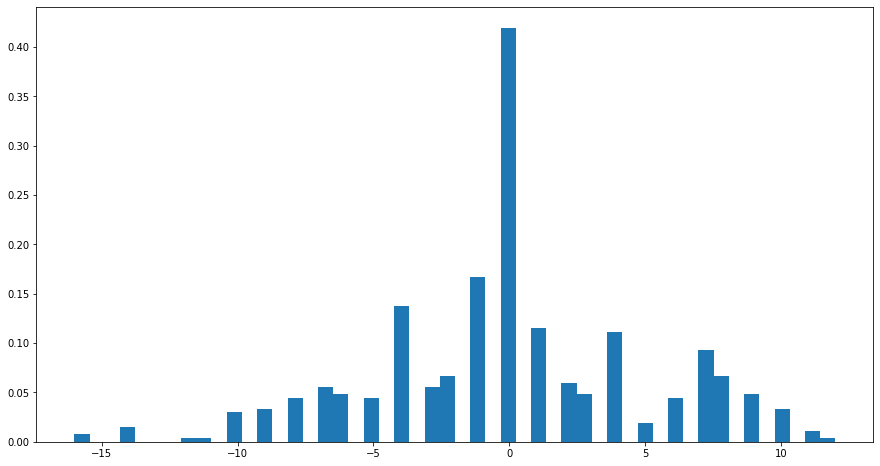

In [39]:
# Отобразим разность предсказаний на гистограмме
diff = model_nb.y_predictions - model_nb.y_test
plt.figure(figsize=(15, 8))
plt.hist(diff, bins=50, density=True)
plt.show()

In [40]:
# Показатели отчета не убедительные. Попробуем построить классификатор по модели KNN 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype='int')}

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, knn_grid, cv=5)

# Обучаем его
model_knn=Classifier(X,y,model=gs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


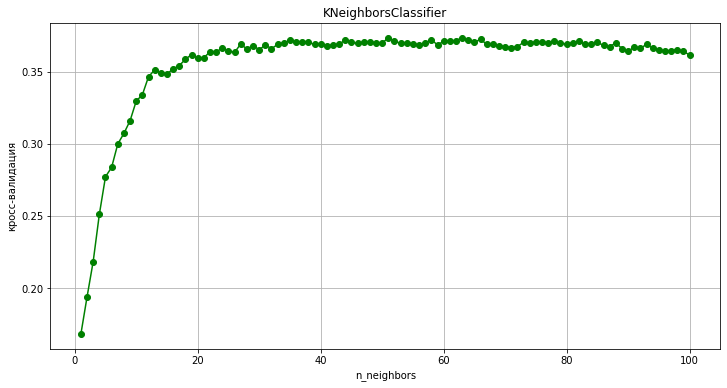

In [41]:
def grid_plot(x, y, x_label, title, y_label='кросс-валидация'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
grid_plot(knn_grid['n_neighbors'], model_knn.model.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [42]:
# Лучшие параметры
model_knn.model.best_params_, model_knn.model.best_score_

({'n_neighbors': 63}, 0.3737176200755532)

In [44]:
# Выполним тренировку классификатора с лучшим параметром
clf_knn = KNeighborsClassifier(n_neighbors=63)
model_knn=Classifier(X,y,model=clf_knn)
y_knn = model_knn.model.predict(model_knn.X_test)
model_knn.y_predictions=y_knn
y_knn

array([10, 10, 10, 10,  0,  9, 10,  9, 10,  2,  9,  9,  9,  9,  9,  9,  0,
        9, 10,  9, 10,  5,  9,  2,  3, 10,  9,  9, 10,  3,  9,  2,  9, 10,
        9,  4,  9,  9, 10,  2,  9,  2, 10,  9,  0,  9,  9,  9, 10,  9,  4,
        9,  2,  2,  9,  9,  9,  2,  9, 10,  9,  2,  2,  9, 10,  9,  0,  6,
        2,  2,  9,  9, 10,  9,  9,  5,  2,  9,  6,  9,  2,  9, 10,  9,  5,
        9, 10,  6,  2,  5,  2,  9,  9,  9,  2,  9,  9,  9,  9,  9,  9,  0,
        9,  2,  9, 10,  2,  9, 10,  4,  0,  9,  9,  6,  9,  9,  0,  6,  9,
        9,  2,  9,  9,  9, 10,  9, 11,  9,  9, 10,  9,  2,  2,  9, 10, 10,
        9,  9,  9, 10,  9, 10,  2,  9,  9,  4,  9,  9, 10, 10,  9, 10,  2,
        9,  9,  9, 10,  9, 11,  2,  2,  0, 10, 10,  6,  2,  9,  9, 10,  6,
        9,  9,  2,  3,  9,  2,  9, 10,  9,  0,  2,  2,  4,  9, 10,  9,  2,
       10, 10,  9,  3,  9,  9, 10,  5, 10, 10,  9,  2,  9,  9,  2,  9, 10,
       10, 10,  2,  9,  9, 10, 10,  2,  9,  9,  9,  9,  9,  9,  0,  2, 10,
        9,  9,  4,  9,  9

In [47]:
# Посмотрим на метрики качества
print('Модель KNN')
model_knn.getReport()
print('Модель NB')
model_nb.getReport()

Модель KNN
              precision    recall  f1-score   support

           0       0.33      0.16      0.22        37
           1       0.00      0.00      0.00         5
           2       0.31      0.46      0.37        59
           3       0.44      0.44      0.44        16
           4       0.33      0.80      0.47         5
           5       0.19      0.06      0.09        52
           6       0.11      0.13      0.12        15
           7       0.00      0.00      0.00         1
           8       0.50      0.06      0.10        18
           9       0.38      0.69      0.49       119
          10       0.43      0.44      0.44        90
          11       0.67      0.11      0.19        18
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00        15

    accuracy   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Как видно, результат улучшился, но не настолько как бы нам хотелось. Делаем вывод, что проблема с данными, а именно их недостаточностью/не уникальностью для каждого класса.

In [59]:
# Выполним классификацию по запросу
text = ['i want to learn cloud computing']
model_knn.classify(text)
print(model_knn.predictions)


Predictions: ['cloud computing']
Predictions for all classes: [[0.06349206 0.         0.41269841 0.03174603 0.         0.14285714
  0.         0.         0.04761905 0.12698413 0.12698413 0.03174603
  0.         0.         0.         0.         0.01587302]]
['cloud computing']


In [60]:
# На основе релевантности направлений, сформируем предложение курсов, учитывая их рейтинг и оценки
df_all.loc[df_all['direction']==model_knn.predictions[0]].sort_values(['marks','raiting'], ascending=False).head(10)

,title,descr,marks,raiting,url,direction,words count
490,The Bits and Bytes of Computer Networking,"['course', 'designed', 'provide', 'full', 'ove...",28880,4.7,https://www.coursera.org/learn/computer-networ...,cloud computing,665
282,Tools for Data Science,"['popular', 'data', 'science', 'tools', 'use',...",21329,4.5,https://www.coursera.org/learn/open-source-too...,cloud computing,626
296,Essential Google Cloud Infrastructure: Foundation,"['accelerated', 'course', 'introduces', 'parti...",14717,4.7,https://www.coursera.org/learn/gcp-infrastruct...,cloud computing,1170
534,System Administration and IT Infrastructure Se...,"['course', 'transition', 'working', 'single', ...",14304,4.7,https://www.coursera.org/learn/system-administ...,cloud computing,1322
291,AWS Fundamentals: Going Cloud-Native,"['course', 'introduce', 'amazon', 'web', 'serv...",12419,4.7,https://www.coursera.org/learn/aws-fundamental...,cloud computing,1649
297,Algorithmic Toolbox,"['course', 'covers', 'basic', 'algorithmic', '...",10594,4.6,https://www.coursera.org/learn/algorithmic-too...,cloud computing,624
304,Essential Google Cloud Infrastructure: Core Se...,"['accelerated', 'course', 'introduces', 'parti...",10170,4.7,https://www.coursera.org/learn/gcp-infrastruct...,cloud computing,1026
319,Introduction to Big Data,"['interested', 'increasing', 'knowledge', 'big...",9666,4.6,https://www.coursera.org/learn/big-data-introd...,cloud computing,2535
312,Elastic Google Cloud Infrastructure: Scaling a...,"['accelerated', 'course', 'introduces', 'parti...",8180,4.7,https://www.coursera.org/learn/gcp-infrastruct...,cloud computing,975
326,A Crash Course in Data Science,"['definitely', 'heard', 'data', 'science', 'bi...",7542,4.5,https://www.coursera.org/learn/data-science-co...,cloud computing,1221
